In [1]:
from ola_cb import * 
from ola_RNN import * 
from ola_models import * 

import os, time, copy, math, re, json, pickle, random
import numpy as np
import pandas as pd

import torch, torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from functools import partial 

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

path = !pwd
path = path[0]
print(path)

using device cuda:0
/home/r2/Documents/RNNexp


In [7]:
bs  = 20
sql = 30 
lr  = 0.0005 

sched = combine_scheds([0.15, 0.25, 0.2, 0.4], [sched_cos(0.0005, 0.0008), sched_cos(0.0008, 0.0005),sched_lin(0.0005,0.0005),sched_cos(0.0005,0.00005)]) 
data          = pp_trumpdata(path+"/data/trump/", [0.9,0.95], bs)
data.train_dl = TweetDataLoader(data,data.train.tweets,bs,sql,shuffle=True)
data.valid_dl = TweetDataLoader(data,data.valid.tweets,bs,sql,shuffle=False)

model  = cuda(GRU(len(data.decoder), 150))
opt    = optim.RMSprop(model.parameters(), lr)
learn  = Learner(model,  nn.NLLLoss(), opt , data, lr=lr)
# , , ParamScheduler('lr',sched)]) StatsCallback()

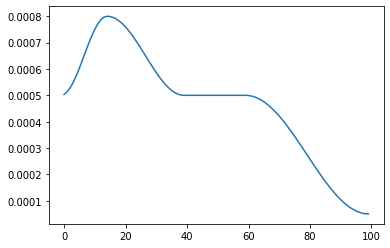

In [8]:
print_sched(sched)

In [101]:
cbs    = CallbackHandler([CounterCallback(5000),StatsCallback()])

In [102]:
fit_gru(1,learn,cbs)

getting validation
finished: 0.01999999999999999%


KeyboardInterrupt: 

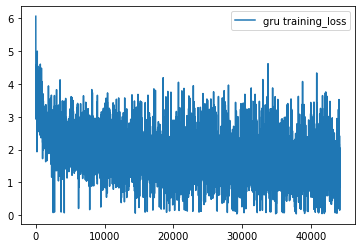

In [117]:
plt.figure()
plt.plot([x for x in range(len(learn.stats.train_loss))],learn.stats.train_loss,label='gru training_loss')
plt.legend()      
plt.savefig('./exps/1/grutrloss')

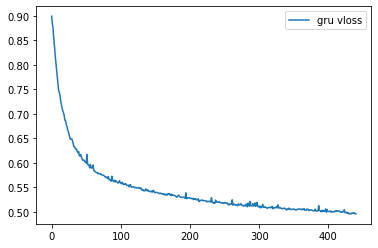

In [119]:
plt.figure()
plt.plot([x for x in range(len(learn.stats.valid_loss))],learn.stats.valid_loss,label='gru vloss')
plt.legend()      
learn.stats.valid_loss[-1]
plt.savefig('./exps/1/gruvloss')

In [ ]:
plt.figure()
plt.plot([x for x in range(len(learn.stats.lrs))],learn.stats.lrs,label='learningrate')
plt.legend()      

In [78]:
generate_seq(learn.model,learn.data,300)

^. fast never goin bett last see would net the Washi Amab!€!€h to give out. #NeroheSton Siek poll nice soneanord.€.Chrol to hasps cand out real step time to approvally will the @BCAMMERAT"€Cital #TrumpDett2016 #NetermanD Strong in Fanists aure: https://t.co/FON
f6XhSP€"€€/MaryGre8, &amp; seelly in ti


In [92]:
model2  = cuda(RNN(len(data.decoder), 150))
opt2    = optim.RMSprop(model2.parameters(), lr)
learn2  = Learner(model2,  nn.NLLLoss(), opt2 , data, lr=lr)

In [105]:
fit_rnn(1, learn2, cbs)

getting validation
finished: 0.01999999999999999%
getting validation
finished: 0.03999999999999987%
getting validation
finished: 0.05999999999999975%
getting validation
finished: 0.08000000000000024%
getting validation
finished: 0.10000000000000081%
getting validation
finished: 0.12000000000000138%
getting validation
finished: 0.14000000000000196%
getting validation
finished: 0.16000000000000253%
getting validation
finished: 0.1800000000000031%
getting validation
finished: 0.20000000000000367%
getting validation
finished: 0.22000000000000425%
getting validation
finished: 0.24000000000000482%
getting validation
finished: 0.260000000000004%
getting validation
finished: 0.2800000000000018%
getting validation
finished: 0.2999999999999996%
getting validation
finished: 0.3199999999999974%
getting validation
finished: 0.3399999999999952%
getting validation
finished: 0.359999999999993%
getting validation
finished: 0.3799999999999908%
getting validation
finished: 0.3999999999999886%
getting val

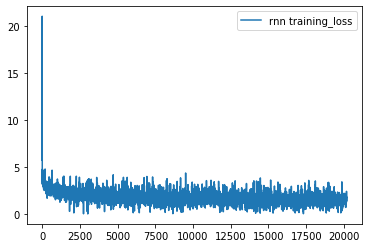

In [120]:
plt.figure()
plt.plot([x for x in range(len(learn2.stats.train_loss))],learn2.stats.train_loss,label='rnn training_loss')
plt.legend()      
plt.savefig('./exps/1/rnntrloss')

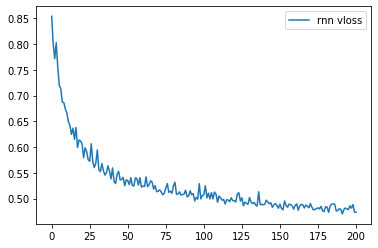

In [121]:
plt.figure()
plt.plot([x for x in range(len(learn2.stats.valid_loss))],learn2.stats.valid_loss,label='rnn vloss')
plt.legend()      
learn2.stats.valid_loss[-1]
plt.savefig('./exps/1/rnnvloss')